# 인공신경망을 이용한 주택가격지수 예측

In [141]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [142]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Dropout, LeakyReLU
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
import tensorflow as tf
import pydot
import graphviz 
from numpy import unique
from numpy import argmax
import math
from imblearn.over_sampling import SMOTE

In [143]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AI 2021/Dataset/house_dataset(new).csv")

In [144]:
for i in range(df.shape[0]):
    df["Date"][i]=df["Date"][i][0:4]+df["Date"][i][6:-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [145]:
X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

In [146]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

### Train : 0~143( ~ 2018)
### test : 144~ (2019 ~)

In [147]:
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [148]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression as mi
split_std = 133
window_size=12
y_train = y.iloc[:split_std]
y_test = y.iloc[split_std:]
y_test_w = y.iloc[split_std-window_size:]

X_new = pd.DataFrame(SelectKBest(mi, k=4).fit_transform(X, y))

X_train=X_new.iloc[:split_std,]
X_test=X_new.iloc[split_std:,]
X_test_w=X_new.iloc[split_std-window_size:,]

trainX, trainY = make_dataset(X_train,y_train, window_size)
testX, testY = make_dataset(X_test_w,y_test_w, window_size)

In [149]:
print(X_test.shape)
print(y_test.shape)
print(testX.shape)
print(testY.shape)

(17, 4)
(17,)
(17, 12, 4)
(17,)


# MLP
---

In [150]:
n_features = X_train.shape[1]
# define the keras model
model = Sequential()
model.add(Dense(128, input_dim=n_features, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

# compile the keras model
model.compile(loss='mse', optimizer='adam')

# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=1000, batch_size=16, verbose=2)

# evaluate on test set
preds = model.predict(X_test)
preds1=np.reshape(preds,(preds.shape[0],))

case1 = np.concatenate((y_train,preds1),axis=0)

tf.keras.backend.clear_session()

Epoch 1/1000
9/9 - 0s - loss: 7622.3428
Epoch 2/1000
9/9 - 0s - loss: 7339.6514
Epoch 3/1000
9/9 - 0s - loss: 7029.4775
Epoch 4/1000
9/9 - 0s - loss: 6598.7803
Epoch 5/1000
9/9 - 0s - loss: 6177.7969
Epoch 6/1000
9/9 - 0s - loss: 5660.0718
Epoch 7/1000
9/9 - 0s - loss: 5103.2808
Epoch 8/1000
9/9 - 0s - loss: 4320.9619
Epoch 9/1000
9/9 - 0s - loss: 3725.8677
Epoch 10/1000
9/9 - 0s - loss: 2929.4062
Epoch 11/1000
9/9 - 0s - loss: 2558.9482
Epoch 12/1000
9/9 - 0s - loss: 2169.5969
Epoch 13/1000
9/9 - 0s - loss: 1822.6241
Epoch 14/1000
9/9 - 0s - loss: 1482.6492
Epoch 15/1000
9/9 - 0s - loss: 1389.2665
Epoch 16/1000
9/9 - 0s - loss: 1241.2554
Epoch 17/1000
9/9 - 0s - loss: 1122.4286
Epoch 18/1000
9/9 - 0s - loss: 1089.6831
Epoch 19/1000
9/9 - 0s - loss: 1009.7867
Epoch 20/1000
9/9 - 0s - loss: 982.9806
Epoch 21/1000
9/9 - 0s - loss: 869.2988
Epoch 22/1000
9/9 - 0s - loss: 858.5759
Epoch 23/1000
9/9 - 0s - loss: 753.1894
Epoch 24/1000
9/9 - 0s - loss: 707.3808
Epoch 25/1000
9/9 - 0s - loss:

# LSTM

In [151]:
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential()
model.add(LSTM(16, input_shape=(trainX.shape[1], trainX.shape[2]),activation='relu',return_sequences=False ))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))


model.compile(loss='mse', optimizer="adam")
model.fit(trainX, trainY, epochs=1000, batch_size=16, verbose=2)

# evaluate on test set
preds = model.predict(testX)

preds2=np.reshape(preds,(preds.shape[0],))

case2 = np.concatenate((trainY,preds2),axis=0)

tf.keras.backend.clear_session()

Epoch 1/1000
8/8 - 1s - loss: 8002.7490
Epoch 2/1000
8/8 - 0s - loss: 7990.1021
Epoch 3/1000
8/8 - 0s - loss: 7970.9434
Epoch 4/1000
8/8 - 0s - loss: 7962.2349
Epoch 5/1000
8/8 - 0s - loss: 7946.0298
Epoch 6/1000
8/8 - 0s - loss: 7914.0273
Epoch 7/1000
8/8 - 0s - loss: 7872.9292
Epoch 8/1000
8/8 - 0s - loss: 7683.4102
Epoch 9/1000
8/8 - 0s - loss: 7262.9980
Epoch 10/1000
8/8 - 0s - loss: 6287.8027
Epoch 11/1000
8/8 - 0s - loss: 7103.8955
Epoch 12/1000
8/8 - 0s - loss: 6599.2305
Epoch 13/1000
8/8 - 0s - loss: 6114.2578
Epoch 14/1000
8/8 - 0s - loss: 5828.7637
Epoch 15/1000
8/8 - 0s - loss: 4817.9395
Epoch 16/1000
8/8 - 0s - loss: 3338.9790
Epoch 17/1000
8/8 - 0s - loss: 3022.7593
Epoch 18/1000
8/8 - 0s - loss: 2416.4995
Epoch 19/1000
8/8 - 0s - loss: 2504.8806
Epoch 20/1000
8/8 - 0s - loss: 1753.3618
Epoch 21/1000
8/8 - 0s - loss: 1873.8523
Epoch 22/1000
8/8 - 0s - loss: 1395.0354
Epoch 23/1000
8/8 - 0s - loss: 1531.2535
Epoch 24/1000
8/8 - 0s - loss: 1467.3696
Epoch 25/1000
8/8 - 0s - 

In [152]:
print(preds.shape)
print(testY.shape)
print(testX.shape)

(17, 1)
(17,)
(17, 12, 4)


# GRU
---

In [153]:
from tensorflow.keras.layers import GRU

model = Sequential()
model.add(GRU(16, input_shape=(trainX.shape[1], trainX.shape[2]),activation='relu',return_sequences=False ))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))


model.compile(loss='mse', optimizer="adam")
model.fit(trainX, trainY, epochs=1000, batch_size=16, verbose=2)

# evaluate on test set
preds = model.predict(testX)

preds3=np.reshape(preds,(preds.shape[0],))

case3 = np.concatenate((trainY,preds3),axis=0)

tf.keras.backend.clear_session()

Epoch 1/1000
8/8 - 1s - loss: 7988.9131
Epoch 2/1000
8/8 - 0s - loss: 7963.3115
Epoch 3/1000
8/8 - 0s - loss: 7961.6099
Epoch 4/1000
8/8 - 0s - loss: 7924.8218
Epoch 5/1000
8/8 - 0s - loss: 7910.6284
Epoch 6/1000
8/8 - 0s - loss: 7903.0684
Epoch 7/1000
8/8 - 0s - loss: 7885.4497
Epoch 8/1000
8/8 - 0s - loss: 7864.3867
Epoch 9/1000
8/8 - 0s - loss: 7866.3613
Epoch 10/1000
8/8 - 0s - loss: 7842.3828
Epoch 11/1000
8/8 - 0s - loss: 7795.9858
Epoch 12/1000
8/8 - 0s - loss: 7776.1177
Epoch 13/1000
8/8 - 0s - loss: 7705.2563
Epoch 14/1000
8/8 - 0s - loss: 7636.0444
Epoch 15/1000
8/8 - 0s - loss: 7504.3545
Epoch 16/1000
8/8 - 0s - loss: 6982.8452
Epoch 17/1000
8/8 - 0s - loss: 5781.7842
Epoch 18/1000
8/8 - 0s - loss: 3958.3499
Epoch 19/1000
8/8 - 0s - loss: 3200.8098
Epoch 20/1000
8/8 - 0s - loss: 1939.9777
Epoch 21/1000
8/8 - 0s - loss: 1713.9590
Epoch 22/1000
8/8 - 0s - loss: 1737.4044
Epoch 23/1000
8/8 - 0s - loss: 1530.5723
Epoch 24/1000
8/8 - 0s - loss: 1656.9170
Epoch 25/1000
8/8 - 0s - 

# CNN
---

In [154]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LeakyReLU, PReLU


model = Sequential()
model.add(Conv1D(activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), strides=9, filters=5, kernel_size=5))
# model.add(Dropout(0.5))
# model.add(Conv1D(strides=8, filters=4, kernel_size=3))
model.add(Dense(1, activation='linear'))
# model.add(LeakyReLU())


model.compile(loss='mse', optimizer='adam')

model.fit(trainX, trainY, epochs=1000, batch_size=32, verbose=2)

# evaluate on test set
preds = model.predict(testX)
print(y_test.shape)
print(testY.shape)
print(preds.shape)
preds4=np.reshape(preds,(preds.shape[0],))

case4 = np.concatenate((trainY,preds4),axis=0)

tf.keras.backend.clear_session()

Epoch 1/1000
4/4 - 0s - loss: 7983.8345
Epoch 2/1000
4/4 - 0s - loss: 7978.8828
Epoch 3/1000
4/4 - 0s - loss: 7974.5820
Epoch 4/1000
4/4 - 0s - loss: 7969.9629
Epoch 5/1000
4/4 - 0s - loss: 7965.5825
Epoch 6/1000
4/4 - 0s - loss: 7961.3833
Epoch 7/1000
4/4 - 0s - loss: 7957.2861
Epoch 8/1000
4/4 - 0s - loss: 7953.1270
Epoch 9/1000
4/4 - 0s - loss: 7949.0229
Epoch 10/1000
4/4 - 0s - loss: 7944.7715
Epoch 11/1000
4/4 - 0s - loss: 7940.4155
Epoch 12/1000
4/4 - 0s - loss: 7935.7271
Epoch 13/1000
4/4 - 0s - loss: 7931.0654
Epoch 14/1000
4/4 - 0s - loss: 7926.4482
Epoch 15/1000
4/4 - 0s - loss: 7921.5532
Epoch 16/1000
4/4 - 0s - loss: 7916.3774
Epoch 17/1000
4/4 - 0s - loss: 7911.0259
Epoch 18/1000
4/4 - 0s - loss: 7905.7095
Epoch 19/1000
4/4 - 0s - loss: 7899.8286
Epoch 20/1000
4/4 - 0s - loss: 7893.9683
Epoch 21/1000
4/4 - 0s - loss: 7887.9399
Epoch 22/1000
4/4 - 0s - loss: 7881.3765
Epoch 23/1000
4/4 - 0s - loss: 7874.7788
Epoch 24/1000
4/4 - 0s - loss: 7868.2603
Epoch 25/1000
4/4 - 0s - 

# matplot graph

In [155]:
# plt.figure(figsize=(12, 6))
# x_date = df.iloc[:,0]
# plt.plot(x_date,case1, color="salmon")
# plt.plot(x_date,case2, color="seagreen")
# plt.plot(x_date,case3, color="deeppink")
# plt.plot(x_date,case4, color="teal")
# plt.plot(x_date,y, color="black")
# plt.legend(['MLP','LSTM','GRU','CNN', 'real'])
# plt.xticks(ticks=x_date, rotation=45)
# plt.locator_params(axis='x', nbins=x_date.shape[0]/12)
# plt.show()

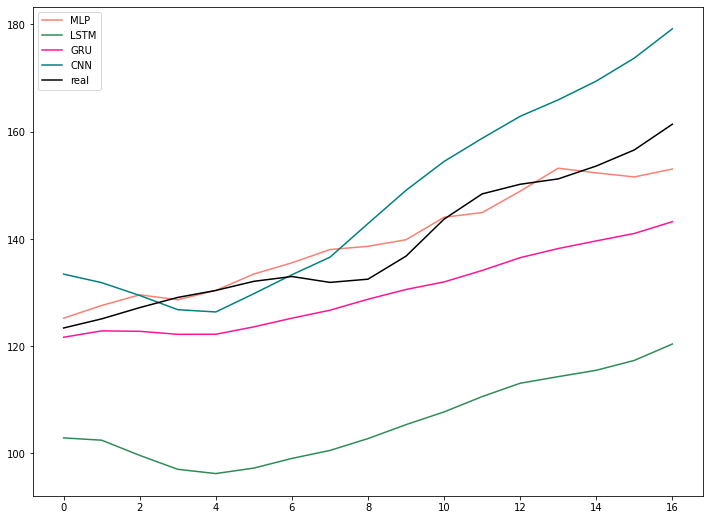

In [156]:
plt.figure(figsize=(12, 9))
plt.plot(preds1, color="salmon")
plt.plot(preds2, color="seagreen")
plt.plot(preds3, color="deeppink")
plt.plot(preds4, color="teal")
plt.plot(testY, color="black")
plt.legend(['MLP','LSTM','GRU','CNN', 'real'])
plt.show()

In [157]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def Eval(y_true,y_pred):
  mae=mean_absolute_error(y_true,y_pred)
  rmse=mean_squared_error(y_true, y_pred)**0.5
  return mae,rmse

arr=[Eval(y_test,preds1), Eval(testY,preds2), Eval(testY,preds3), Eval(testY,preds4),]
buf=np.zeros((1,8))
for i in range(len(arr)):
    buf[0][i*2]=arr[i][0]
    buf[0][i*2+1]=arr[i][1]
result=pd.DataFrame(buf)
result.columns=['MLP_MAE','MLP_RMSE',
                'LSTM_MAE','LSTM_RMSE',
               'GRU_MAE','GRU_RMSE',
               'CNN_MAE','CNN_RMSE']

In [158]:
result

,MLP_MAE,MLP_RMSE,LSTM_MAE,LSTM_RMSE,GRU_MAE,GRU_RMSE,CNN_MAE,CNN_RMSE
0,2.831992,3.621727,33.18411,33.631197,9.130443,10.343086,9.094743,10.62743


In [159]:
import os
if not os.path.exists('/content/drive/MyDrive/Colab Notebooks/AI 2021/result_Other_Deep.csv'):
    result.to_csv('/content/drive/MyDrive/Colab Notebooks/AI 2021/result_Other_Deep.csv', index=False, mode='w', encoding='utf-8-sig')
else:
    result.to_csv('/content/drive/MyDrive/Colab Notebooks/AI 2021/result_Other_Deep.csv', index=False, mode='a', encoding='utf-8-sig', header=False)